In [27]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import pandas as pd
import numpy as np
import copy
%aimport BEP_PM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# log = importer.apply('C:/Users/20173939/Documents/Study/BEP/Road_Traffic_Fine_Management_Process.xes')
# rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log)
# rf.clean_timezone()
# rf.save()

In [29]:
# Reloading an already saved log named 'roadfines':
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', resource_id='org:resource')

In [30]:
rf.event_count

{('Create Fine', 'Send Fine'): 20755,
 ('Create Fine', 'Send for Credit Collection'): 58997,
 ('Create Fine', 'Payment'): 67201,
 ('Create Fine', 'Send Appeal to Prefecture'): 3144,
 ('Create Fine', 'Appeal to Judge'): 134,
 ('Create Fine', 'Notify Result Appeal to Offender'): 86,
 ('Create Fine', 'Receive Result Appeal from Prefecture'): 53}

In [31]:
# Manual reordering to match paper's segment order:
segments = rf.filter_segments()
segments[-1], segments[-2] = segments[-2], segments[-1] 
segments.insert(0, segments.pop(-1))
segments[-1], segments[-2] = segments[-2], segments[-1] 

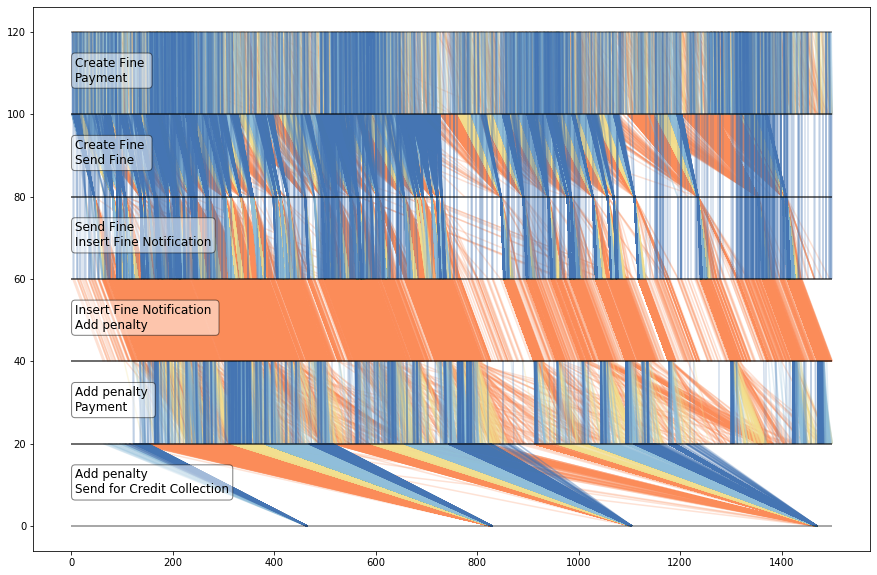

In [32]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.performance_spectrum(segments, x_max=int(1500))
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, metric='duration', classifier=rf.classify_duration_hist, args=[4])

In [33]:
# Using batch classifier to indicate if corrected trace was in a batch.
# This is because it is hard to see which traces where batched once the times have been adjusted.

# Sort per resource.
df = rf.pf.sort_values(['resource','start_time'])
df = rf.classify(df, metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0])
current = None
last_end = None
prev = None
corrected = {}
causes = {}
for ind, row in df.iterrows():
    if row['resource'] != current: # Switching to new resource. 
        current = row['resource']
        last_end = None
    if last_end is not None and last_end['end_time'] > row['start_time']:
        # The worker was busy during the start of this event, correcting.
        corrected[prev] = row['start_time']
        if last_end['class'] == 0:
            causes[prev] = 0  # No batch, but still a cause. 
        else:
            causes[prev] = 1  # Batch is cause.
    last_end = row
    prev = ind
    
df['correct_end'] = df.index.map(corrected)
df['batch'] = df.index.map(causes)
rf.pf = df.sort_index()
rf.pf['waiting_time'] = rf.pf['end_time']-rf.pf['correct_end']
rf.pf['correct_duration'] = rf.pf['correct_end']-rf.pf['start_time']

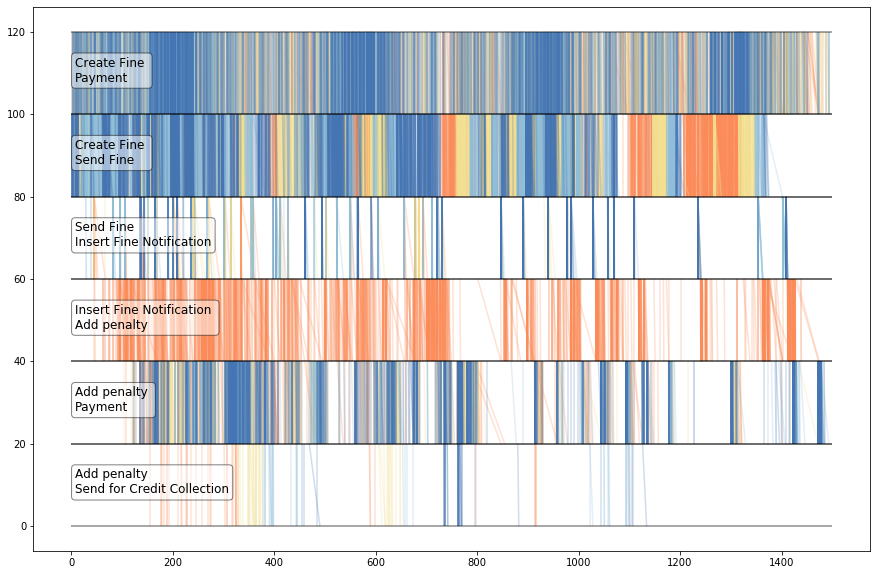

In [36]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=rf.pf['batch'] == 0, end='correct_end', metric='duration', classifier=rf.classify_duration_hist, args=[4])

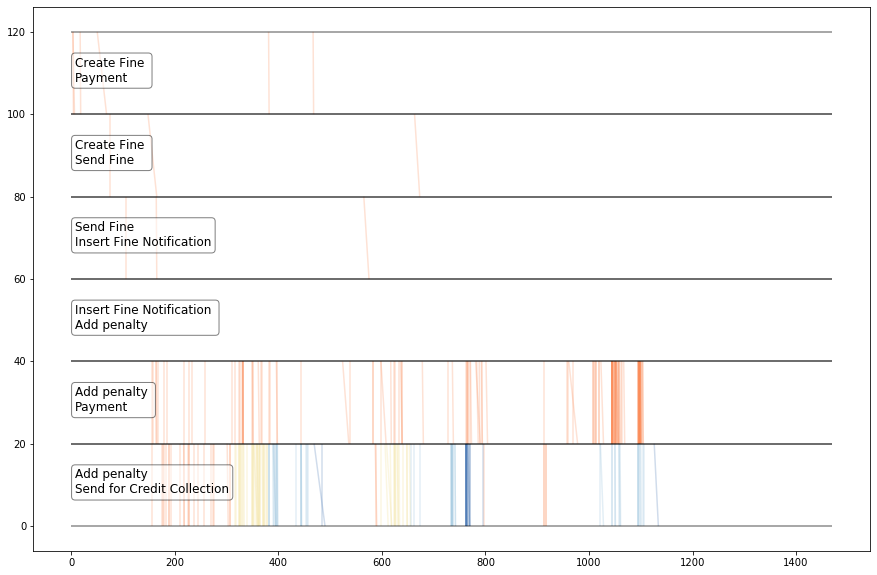

In [47]:
# Outliers in waiting time (time on shelf) that where not in an end-batch.
outliers = ((rf.pf['waiting_time'] - rf.pf['waiting_time'].mean())/rf.pf['waiting_time'].std() > 1) & (rf.pf['batch'] == 0)

class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=outliers, end='correct_end', metric='duration', classifier=rf.classify_duration_hist, args=[4])

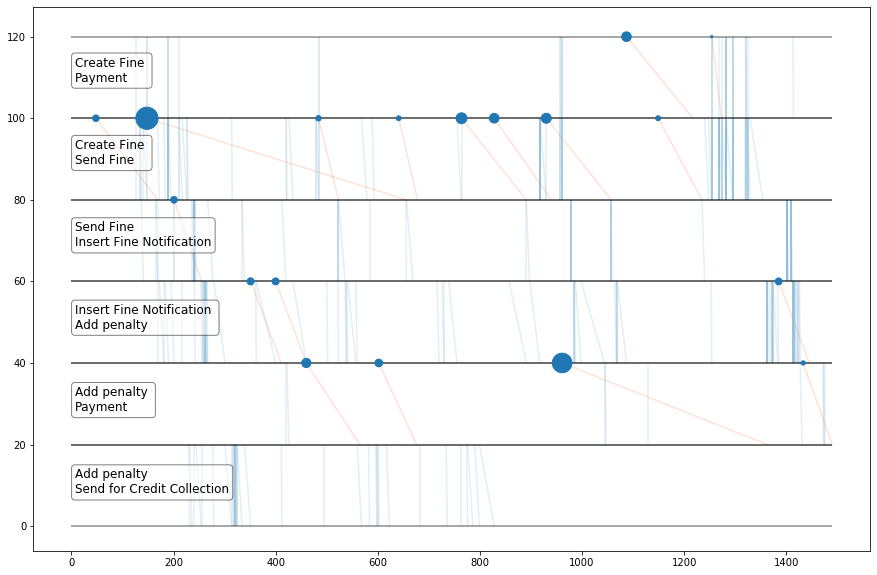

In [67]:
# Rebuilding the Performance Spectrum using corrected end time and corrected duration:
temp = copy.deepcopy(rf)
temp.build_coordinates(temp.pf['start_time'], temp.pf['correct_end'])
# rf.classify(metric='correct_duration', classifier=rf.classify_duration_hist, args=[4])
# mask = rf.pf['waiting_time'] > np.array(rf.pf.groupby('segment_index')['waiting_time'].mean()[rf.pf['segment_index']])
mask = ((rf.pf['correct_duration'] - rf.pf['correct_duration'].mean())/rf.pf['correct_duration'].std() > 3) & (rf.pf['batch'] == 0)
#mask = (rf.pf['class'] == 3) &   (rf.pf['batch'] == 0)
# rf.pf['class'] = 0
# for ind, row in rf.pf[mask].sort_values('waiting_time', ascending=False).head().iterrows():
#     # The lines that caused delay:
#     rf.pf.loc[mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'class'] = 1
#     if sum(mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource'])) != 0:
#         # The delayed segment:
#         rf.pf.loc[rf.pf.index == ind, 'class'] = 2


rf.pf.loc[mask&rf.pf['resource'].isin(most_delayed_resources), 'class'] = 3
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'class'] = 1
rf.build_coordinates(rf.pf['start_time'], rf.pf['end_time'])
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'start'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['start']
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'end'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['end']


most_delayed_resources = list(dict(rf.pf[~rf.pf['delayed'].isna()]['resource'].value_counts()[:1]).keys())
for ind, row in rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)].iterrows():
    # The lines that caused delay:
    rf.pf.loc[(rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'delayer'] = 1

        
fig, ax = plt.subplots(figsize=[15,10])
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.plot_performance_spectrum(class_colors, ax, mask=(mask&rf.pf['resource'].isin(most_delayed_resources))|((rf.pf['resource'].isin(most_delayed_resources)) & (~mask) & (rf.pf['delayer'] == 1)))


# Adding a scatter plot with the waiting time for traces.
ax.scatter(rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_time'], rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_y'], s=rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['waiting_time'], zorder=10)

(array([   0,   28,   56,   84,  112,  140,  168,  196,  224,  252,  280,
         308,  336,  364,  392,  420,  448,  476,  504,  532,  560,  588,
         616,  644,  672,  700,  728,  756,  784,  812,  840,  868,  896,
         924,  952,  980, 1008, 1036, 1064, 1092, 1120, 1148, 1176, 1204,
        1232, 1260, 1288, 1316, 1344, 1372, 1400, 1428, 1456, 1484]),
 <a list of 54 Text xticklabel objects>)

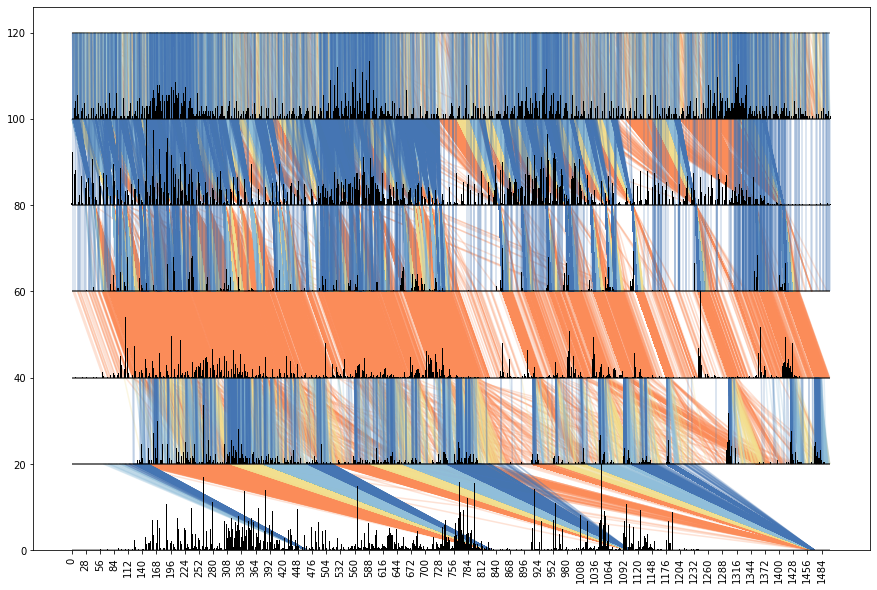

In [19]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax)
window=7
for s in range(len(segments)):
    df = rf.pf[rf.pf['segment_index'] == s]
    load_in_window = {i:[] for i in df['resource'].unique()}
    for i in range(0, max(df['end_time']), window):
        workload = dict(df[(df['start_time'] >= i) & (df['start_time'] <= i+window)].groupby('resource').count()['start_time'])
        for resource in df['resource'].unique():
            if resource in workload.keys():
                load_in_window[resource].append(workload[resource])
            else:
                load_in_window[resource].append(0)
    x, height = [],[]
    for k in range(len(load_in_window[list(load_in_window.keys())[0]])):
        load_per_time = list(pd.DataFrame(load_in_window).transpose()[k])
        x.extend([(k*7)+(window/len(load_per_time))*i for i in range(len(load_per_time))])
        height.extend([load for load in load_per_time])
    height = np.array(height)
    height = ((height-height.min()) / (height.max()-height.min())) * 20
    ax.bar(x,height, bottom=rf.y_s[s][1], color=(0,0,0),  zorder=10)
ax.set_xticks([i for i in range(0, rf.x_max, 28)])
plt.xticks(rotation=90)

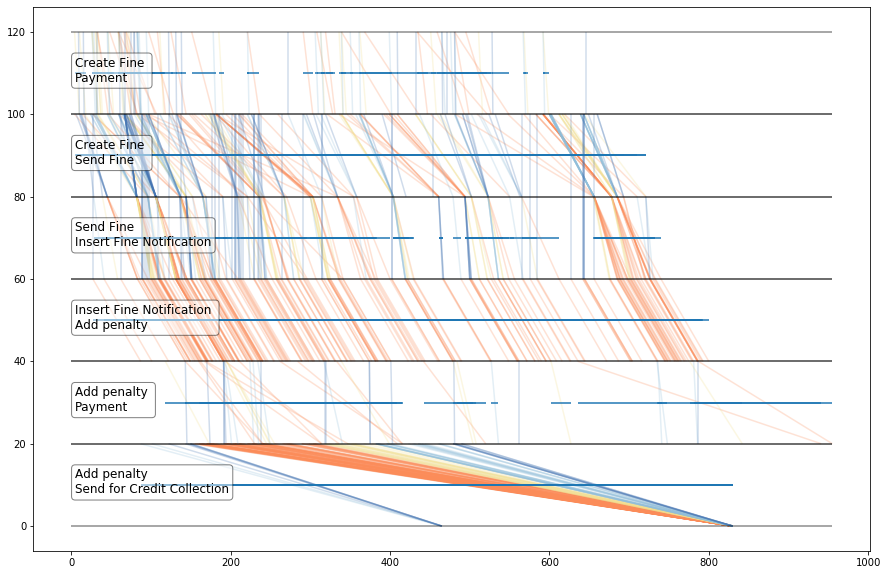

In [252]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000) & (rf.pf['resource'] == '27'))

y_s = [i for i in range(110, 0, -20)]
lines = []
for ind, data in rf.pf[rf.pf['resource'] == '27'].iterrows():
    if data['end_time'] <= 1000:
        line = [(data['start_time'], y_s[data['segment_index']]), (data['end_time'], y_s[data['segment_index']])]
        lines.append(line)
    
ax.add_collection(mc.LineCollection(lines))

In [11]:
workloads = []
for segment in range(len(segments)):
    mask = rf.pf['segment_index'] == segment

    working_times = {}
    for ind, data in rf.pf[mask].iterrows():
        if data['resource'] not in working_times:
            working_times[data['resource']] = [[data['start_time'], data['end_time']]]
        else:
            if data['start_time'] <= working_times[data['resource']][-1][-1]:
                # A resource was already working on something:
                if data['end_time'] > working_times[data['resource']][-1][-1]:
                    # Extending the known working time:
                    working_times[data['resource']][-1][-1] = data['end_time']
            else:
                working_times[data['resource']].append([data['start_time'], data['end_time']])

    workload = {}
    for resource in working_times:
        total = working_times[resource][-1][-1] - working_times[resource][0][0]
        if total == 0:
            workload[resource] = 0
        else:
            worked = sum((working_times[resource][i][1] - working_times[resource][i][0]) for i in range(len(working_times[resource])))
            workload[resource] = worked/total
    workloads.append(workload)

In [9]:
resources = rf.pf['resource'].unique()
load_df = pd.DataFrame(index=resources)
for workload,i in zip(workloads, range(len(segments))):
    for resource in resources:
        if resource not in workload.keys():
            workload[resource] = 0
    load_df['workload at ' + str(i)] = workload.values()

In [10]:
for i in range(len(segments)):
    load_df['mean duration at ' + str(i)] = rf.pf[rf.pf['segment_index'] == i].groupby('resource')['duration'].mean()

In [12]:
working_times

{'26': [[751, 1470]],
 '21': [[683, 1470]],
 '17': [[269, 1470]],
 '28': [[180, 830], [920, 1470]],
 '704': [[131, 1470]],
 '24': [[283, 1105]],
 '10': [[94, 830]],
 '12': [[307, 1470]],
 '16': [[439, 1470]],
 '23': [[725, 1470]],
 '32': [[63, 1105]],
 '35': [[81, 1470]],
 '36': [[77, 1470]],
 '30': [[72, 1470]],
 '31': [[77, 1470]],
 '27': [[87, 1470]],
 '33': [[66, 830]],
 '11': [[149, 1470]],
 '29': [[202, 1470]],
 '34': [[99, 1470]],
 '22': [[284, 830], [1064, 1470]],
 '828': [[312, 1470]],
 '817': [[342, 1105]],
 '826': [[340, 1105]],
 '821': [[216, 1470]],
 '813': [[235, 1105]],
 '829': [[225, 1470]],
 '807': [[216, 830]],
 '825': [[286, 1470]],
 '818': [[339, 1105]],
 '824': [[331, 1470]],
 '827': [[221, 1470]],
 '819': [[306, 1470]],
 '811': [[250, 830]],
 '820': [[353, 1470]],
 '802': [[312, 1470]],
 '823': [[233, 1470]],
 '816': [[307, 1470]],
 '810': [[339, 1470]],
 '830': [[436, 1470]],
 '808': [[287, 830]],
 '832': [[560, 1470]],
 '833': [[559, 1470]],
 '831': [[675, 1470]

In [249]:
load_df

,workload at 0,workload at 1,workload at 2,workload at 3,workload at 4,workload at 5,mean duration at 0,mean duration at 1,mean duration at 2,mean duration at 3,mean duration at 4,mean duration at 5
9,0.144647,0.910995,0.402390,0.677716,0.558783,1.000000,12.569231,87.478571,13.421488,60.0,23.647059,490.166667
27,0.059459,0.226880,0.077121,0.383750,0.025448,1.000000,10.888889,54.417957,21.524306,60.0,53.916667,507.435897
26,0.092460,0.227594,0.080189,0.395857,0.046667,1.000000,15.287500,79.000000,15.685990,60.0,42.032258,453.522727
21,0.449153,0.414545,0.022298,0.220033,0.332759,0.930233,14.326087,80.521472,14.691729,60.0,51.476190,475.607843
28,0.108619,0.217147,0.044130,0.134234,0.486356,1.000000,10.847059,69.392327,18.133229,60.0,41.593220,432.421725
...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.807453,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,60.090909,24.900000,60.0,NaN,542.000000
15,0.952381,1.000000,1.000000,1.000000,0.000000,0.000000,25.586207,83.713043,14.067961,60.0,68.454545,421.086957
19,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,72.000000,8.333333,60.0,NaN,NaN
38,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,13.722222,82.666667,13.714286,60.0,4.000000,NaN


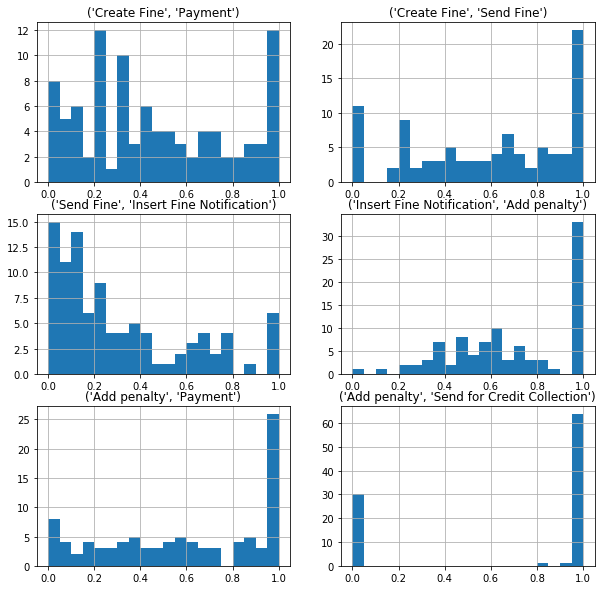

In [218]:
fig, ax = plt.subplots(figsize=[10,10], nrows=int(len(segments)/2), ncols=2)
for i in range(len(segments)):
    load_df[i].hist(bins=20, ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title(segments[i])

In [219]:
working_times = {}
for ind, data in rf.pf.iterrows():
    if data['resource'] not in working_times:
        working_times[data['resource']] = [[data['start_time'], data['end_time']]]
    else:
        if data['start_time'] <= working_times[data['resource']][-1][-1]:
            # A resource was already working on something:
            if data['end_time'] > working_times[data['resource']][-1][-1]:
                # Extending the known working time:
                working_times[data['resource']][-1][-1] = data['end_time']
        else:
            working_times[data['resource']].append([data['start_time'], data['end_time']])

workload = {}
for resource in working_times:
    total = working_times[resource][-1][-1] - working_times[resource][0][0]
    if total == 0:
        workload[resource] = 0
    else:
        worked = sum((working_times[resource][i][1] - working_times[resource][i][0]) for i in range(len(working_times[resource])))
        workload[resource] = worked/total

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
         2.,  2.,  2.,  4.,  6.,  3., 71.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

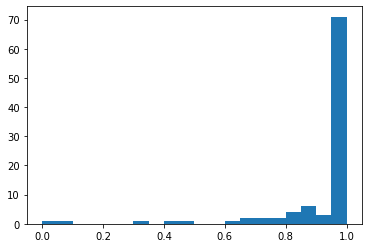

In [223]:
plt.hist(workload.values(), bins=20)

In [15]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPIC15_2.xes.xml')
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp', log)
rf.clean_timezone()
rf.save()

In [16]:
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp')
rf.count_trace_types()

{('01_HOOFD_010', '01_HOOFD_810'): 180,
 ('01_HOOFD_010', '01_HOOFD_820'): 196,
 ('01_HOOFD_010', '01_HOOFD_520'): 9,
 ('01_HOOFD_010', '01_HOOFD_530'): 15,
 ('01_HOOFD_010', '01_HOOFD_805'): 5,
 ('01_HOOFD_010', '01_HOOFD_195'): 2,
 ('01_HOOFD_030_2', '01_HOOFD_820'): 13,
 ('01_HOOFD_010', '01_HOOFD_101'): 4,
 ('01_HOOFD_010', '01_BB_770'): 94,
 ('01_HOOFD_010', '01_HOOFD_065_2'): 1,
 ('01_HOOFD_010', '01_BB_775'): 3,
 ('01_HOOFD_010', '01_HOOFD_516'): 3,
 ('01_HOOFD_010', '01_HOOFD_061'): 3,
 ('01_HOOFD_010', '08_AWB45_090_3'): 2,
 ('01_HOOFD_065_2', '01_HOOFD_516'): 1,
 ('01_HOOFD_010', '01_HOOFD_015'): 4,
 ('01_HOOFD_030_2', '01_HOOFD_195'): 1,
 ('01_HOOFD_010', '01_HOOFD_519'): 3,
 ('01_HOOFD_010', '14_VRIJ_060_3'): 1,
 ('01_HOOFD_010', '01_BB_705'): 1,
 ('01_HOOFD_010', '08_AWB45_025'): 5,
 ('01_HOOFD_010', '02_DRZ_010'): 1,
 ('01_HOOFD_010', '01_HOOFD_815'): 2,
 ('01_HOOFD_010', '01_HOOFD_101b'): 2,
 ('01_HOOFD_010', '16_LGSV_010'): 2,
 ('01_HOOFD_010', '01_HOOFD_250_2'): 1,
 ('

In [17]:
segments = rf.filter_segments(0.50, compare_to='first')

In [18]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]

rf.performance_spectrum(segments, x_max=int(5 * 365), metric='duration', classifier=rf.classify_duration_hist, args=[4])

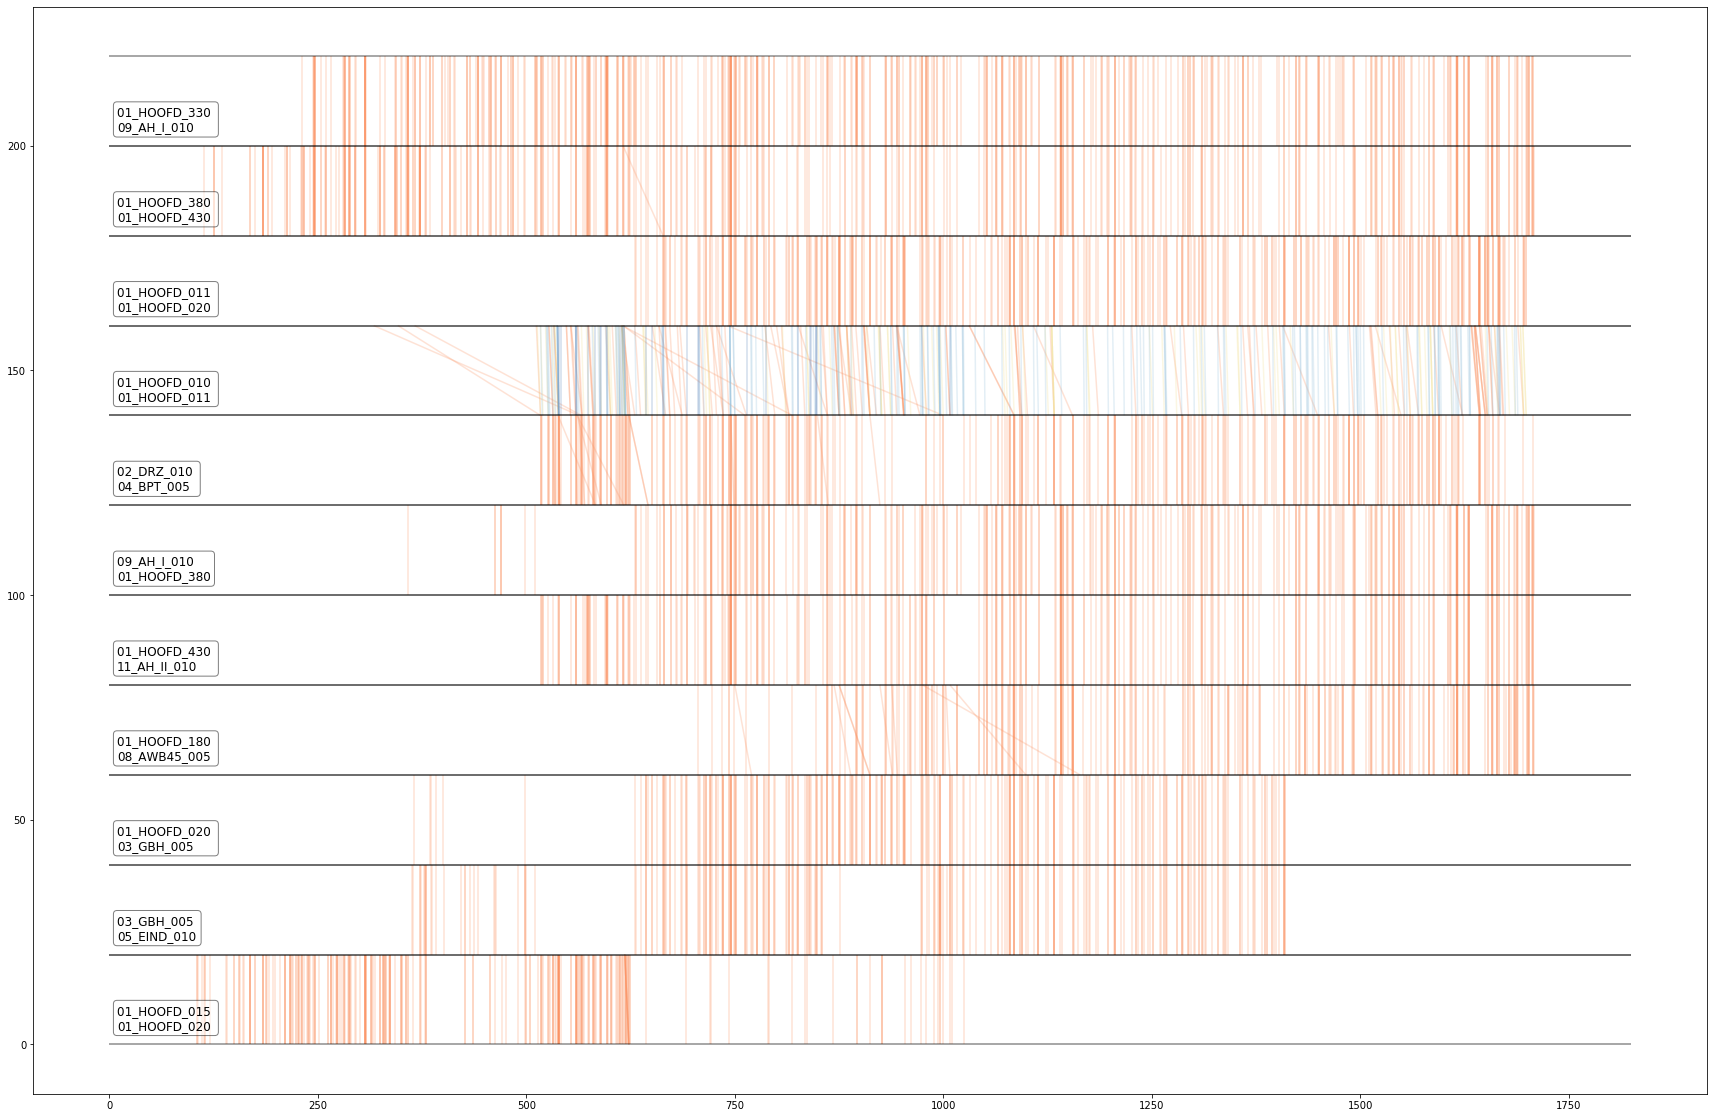

In [20]:
rf.plot_performance_spectrum(class_colors)

In [3]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes')

In [5]:
log[0][0]

{'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_652823628', 'lifecycle:transition': 'complete'}